# In this repo you can finetune any sequence classification transformer model on your dataset

In [1]:
! pip install tensorflow
! pip install nltk
! pip install scikit-learn
! pip install transformers
! pip install datasets
!pip install matplotlib

In [2]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import datetime
import time
import torch
import random
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoModel, AutoTokenizer,BertForSequenceClassification, AdamW, BertConfig,get_linear_schedule_with_warmup
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import precision_recall_fscore_support, classification_report
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

/opt/conda/envs/ptca/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


def normalizeToken(token):
    token = token.strip()
    lowercased_token = token.lower().strip()
    # print(token)
    if token != " ":
        if token.startswith("@"):
            return "@USER"
        elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
            return "HTTPURL"
        # elif len(token) == 1:
        #     return demojize(token)
        else:
            if token == "’":
                return "'"
            elif token == "…":
                return "..."
            else:
                return token


import re
from nltk.tokenize import TweetTokenizer

def normalizeTweet(tweet):
    tweet = str(tweet)  # Convert to string if tweet is a float
    tok = TweetTokenizer()
    tokens = tok.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = normTweet.replace("cannot ", "can not ").replace("n't ", " n't ").replace("n 't ", " n't ").replace("ca n't", "can't").replace("ai n't", "ain't")
    normTweet = normTweet.replace("'m ", " 'm ").replace("'re ", " 're ").replace("'s ", " 's ").replace("'ll "," 'll ").replace("'d ", " 'd ").replace("'ve ", " 've ")
    normTweet = normTweet.replace(" p . m .", "  p.m.").replace(" p . m ", " p.m ").replace(" a . m ."," a.m.").replace(" a . m "," a.m ")
    normTweet = re.sub(r",([0-9]{2,4}) , ([0-9]{2,4})", r",\1,\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3}) / ([0-9]{2,4})", r"\1/\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3})- ([0-9]{2,4})", r"\1-\2", normTweet)
    normTweet = normTweet.lower()
    return " ".join(normTweet.split())


from sklearn.model_selection import train_test_split

# this method just for splitting
def splitting_method(df_, name1 ,name2, test_size = 0.5):
  y = pd.DataFrame(df_, columns = ["label"])
  X = pd.DataFrame(df_, columns = ['sentence'])

  X_train, X_test ,y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=105)

  df_t = pd.DataFrame(X_train, columns = ['sentence'])
  df_yt = pd.DataFrame(y_train, columns = ['label'])

  train_data = pd.concat([df_t, df_yt], axis=1)
  train_data.to_csv(name1+".csv", index = False,)

  df_xtest = pd.DataFrame(X_test, columns = ['sentence'])
  df_ytest = pd.DataFrame(y_test, columns = ['label'])

  test_data = pd.concat([df_xtest, df_ytest], axis=1)
  # print(test_data.isnull().sum())
  if test_size != 0.5:

    test_data = test_data.drop_duplicates('sentence')

  test_data.to_csv(name2+".csv", index = False,)

  # return train_data
  return test_data


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla V100-PCIE-16GB


In [5]:
# CHECKPOINT
CHECKPOINT = "google/mobilebert-uncased"             #change this to the path of your target hugging face model

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    CHECKPOINT,
    num_labels = 50,   #should be changed with another dataset
    output_attentions = False,
    output_hidden_states = False,
    ignore_mismatched_sizes=True,
)

model.to(device)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0): MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_features=1

In [6]:
# DATA loader fun
def Data_to_dataloader(File_name):

  df = pd.read_csv(File_name)

  print('Number of training sentences: {:,}\n'.format(df.shape[0]))
  # print('Number of dev sentences: {:,}\n'.format(df_dev.shape[0]))
  df['sentence']  = df.sentence.apply(normalizeTweet)
  df.dropna()
  # df_dev['sentence']  = df_dev.sentence.apply(normalizeTweet)
  # df_dev.dropna()



  # Get the lists of sentences and their labels.
  sentences = df.sentence.values
  labels = df.label.values
  # sentences_dev = df_dev.sentence.values
  # labels_dev = df_dev.label.values
  tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)


  input_ids = []
  # input_ids_dev = []

  for sent in sentences:
    encoded_sent = tokenizer.encode(sent)
    input_ids.append(encoded_sent)

  # for sent_dev in sentences_dev:
  #   encoded_sent_dev = tokenizer.encode(sent_dev)
  #   input_ids_dev.append(encoded_sent_dev)


  MAX_LEN = 64
  #MAX_LEN = 128
  print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
  print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
  # input_ids_dev = pad_sequences(input_ids_dev, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
  print('\nDone.')
  # Create attention masks


  attention_masks = []
  # attention_masks_dev = []
  for sent in input_ids:
      att_mask = [int(token_id > 0) for token_id in sent]
      attention_masks.append(att_mask)

  # for sent_dev in input_ids_dev:
  #     att_mask_dev = [int(token_id > 0) for token_id in sent_dev]
  #     attention_masks_dev.append(att_mask_dev)


  train_inputs = input_ids
  # validation_inputs = input_ids_dev

  train_labels = labels
  print("train_labels: ",set(train_labels))

  # validation_labels = labels_dev
  # print("validation_labels: ",set(validation_labels))

  train_masks = attention_masks
  # validation_masks = attention_masks_dev

  train_inputs = torch.tensor(train_inputs)
  # validation_inputs = torch.tensor(validation_inputs)

  train_labels = torch.tensor(train_labels)
  print("train_labels: ",train_labels)

  # validation_labels = torch.tensor(validation_labels)
  # print("validation_labels: ",validation_labels)

  train_masks = torch.tensor(train_masks)
  # validation_masks = torch.tensor(validation_masks)


  batch_size = 64
  # Create the DataLoader for our training set.
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  # Create the DataLoader for our validation set.
  # validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  # validation_sampler = SequentialSampler(validation_data)
  # validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

  return train_dataloader

In [7]:
# change the paths to your files
train_dataloader = Data_to_dataloader('/mnt/azureml/cr/j/ec6c81310066482c9f2fcc2c79063234/exe/wd/concated_MC&Corptrain.csv')
validation_dataloader = Data_to_dataloader('/mnt/azureml/cr/j/ec6c81310066482c9f2fcc2c79063234/exe/wd/TopLabeledTest50V3.csv')

Number of training sentences: 965,920




Padding/truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 0

Done.
train_labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
train_labels:  tensor([0, 1, 2,  ..., 7, 7, 7])
Number of training sentences: 123,980


Padding/truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 0

Done.
train_labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
train_labels:  tensor([ 0, 37,  4,  ..., 15, 20,  4])


In [13]:
def train_fun(epoch_i, train_dataloader, model , epochs):

  optimizer = AdamW(model.parameters(),
                    lr = 2e-5,
                    eps = 1e-8
                  )
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)


  # This training code is based on the `run_glue.py` script here:
  # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
  seed_val = 42
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)
  # Store the average loss after each epoch so we can plot them.
  loss_values = []

  # ========================================
  #               Training
  # ========================================
  # Perform one full pass over the training set.
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  print('Training...')
  # Measure how long the training epoch takes.
  t0 = time.time()
  # Reset the total loss for this epoch.
  total_loss = 0
  # Put the model into training mode. Don't be mislead--the call to
  # `train` just changes the *mode*, it doesn't *perform* the training.
  # `dropout` and `batchnorm` layers behave differently during training
  # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
  model.train()

  best_loss = float('inf')  # Initialize best loss to infinity

  for step, batch in enumerate(train_dataloader):

      if step % 40 == 0 and not step == 0:
          elapsed = format_time(time.time() - t0)
          print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      # Always clear any previously calculated gradients before performing a
      # backward pass. PyTorch doesn't do this automatically because
      # accumulating the gradients is "convenient while training RNNs".
      # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
      model.zero_grad()
      # The documentation for this `model` function is here:
      # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
      outputs = model(b_input_ids,
                  token_type_ids=None,
                  attention_mask=b_input_mask,
                  labels=b_labels)

      loss = outputs[0]
      total_loss += loss.item()
      #loss = calc_loss(outputs[1],b_labels)
      #total_loss += loss
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)
  losses.append(avg_train_loss)
  loss_values.append(avg_train_loss)
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

  # Save the model if the current loss is the best so far
  if avg_train_loss < best_loss:
      best_loss = avg_train_loss
      name_save = ' '
      torch.save(model, name_save)

  return loss_values

In [9]:
def macro_score_f1(true_labels,predicted_labels):
    best_labels = []
    for i,label in enumerate(true_labels):
        flag = False
        for l in predicted_labels[i]:
            if l == label:
                best_labels.append(l)
                flag = True
        if not flag: best_labels.append(predicted_labels[i][0])
    #print(len(best_labels))
    #print(len(true_labels))
    macroF1Score = f1_score(true_labels, best_labels, average='macro')
    return macroF1Score


In [10]:
def weighted_score_f1(true_labels,predicted_labels):
    best_labels = []
    for i,label in enumerate(true_labels):
        flag = False
        for l in predicted_labels[i]:
            if l == label:
                best_labels.append(l)
                flag = True
        if not flag: best_labels.append(predicted_labels[i][0])
    #print(len(best_labels))
    #print(len(true_labels))
    macroF1Score = f1_score(true_labels, best_labels, average='weighted')
    return macroF1Score

In [11]:
def test_fun(validation_dataloader, model):
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    predictions, true_labels = [], []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

        predictions.append(logits)
        true_labels.append(label_ids)
    Accs.append(eval_accuracy/nb_eval_steps)
    print('    DONE.')
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
    flat_true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(flat_true_labels, flat_predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(25, 20))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Print the classification report
    classif_rep = classification_report(flat_true_labels, flat_predictions, digits=5)
    print("Classification Report:")
    print(classif_rep)
    ############################################################################################
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argsort(flat_predictions, axis=1)[:, -3:]  # Get the indices of top 3 predictions
    flat_true_labels = [item for sublist in true_labels for item in sublist]

    top3_accuracy = np.mean([1 if true_label in pred_labels else 0 for true_label, pred_labels in zip(flat_true_labels, flat_predictions)])
    print("  Top 3 Accuracy: {0:.2f}".format(top3_accuracy))
    ##############################################################################
    #print(flat_predictions)
    #print(flat_true_labels)
    #x = f1_score(flat_true_labels, flat_predictions, average='macro')
    top3_f1 = macro_score_f1(flat_true_labels,flat_predictions)
    print(f"top 3 macro f1 score : {top3_f1}")
    top3_weightedf1 = weighted_score_f1(flat_true_labels,flat_predictions)
    print(f"top 3 weighted f1 score : {top3_weightedf1}")
    f1score.append(top3_f1)
    top3acc.append(top3_accuracy)
    Top3_weightedf1.append(top3_weightedf1)


Running Validation...
    DONE.
  Accuracy: 0.16
  Validation took: 0:01:26


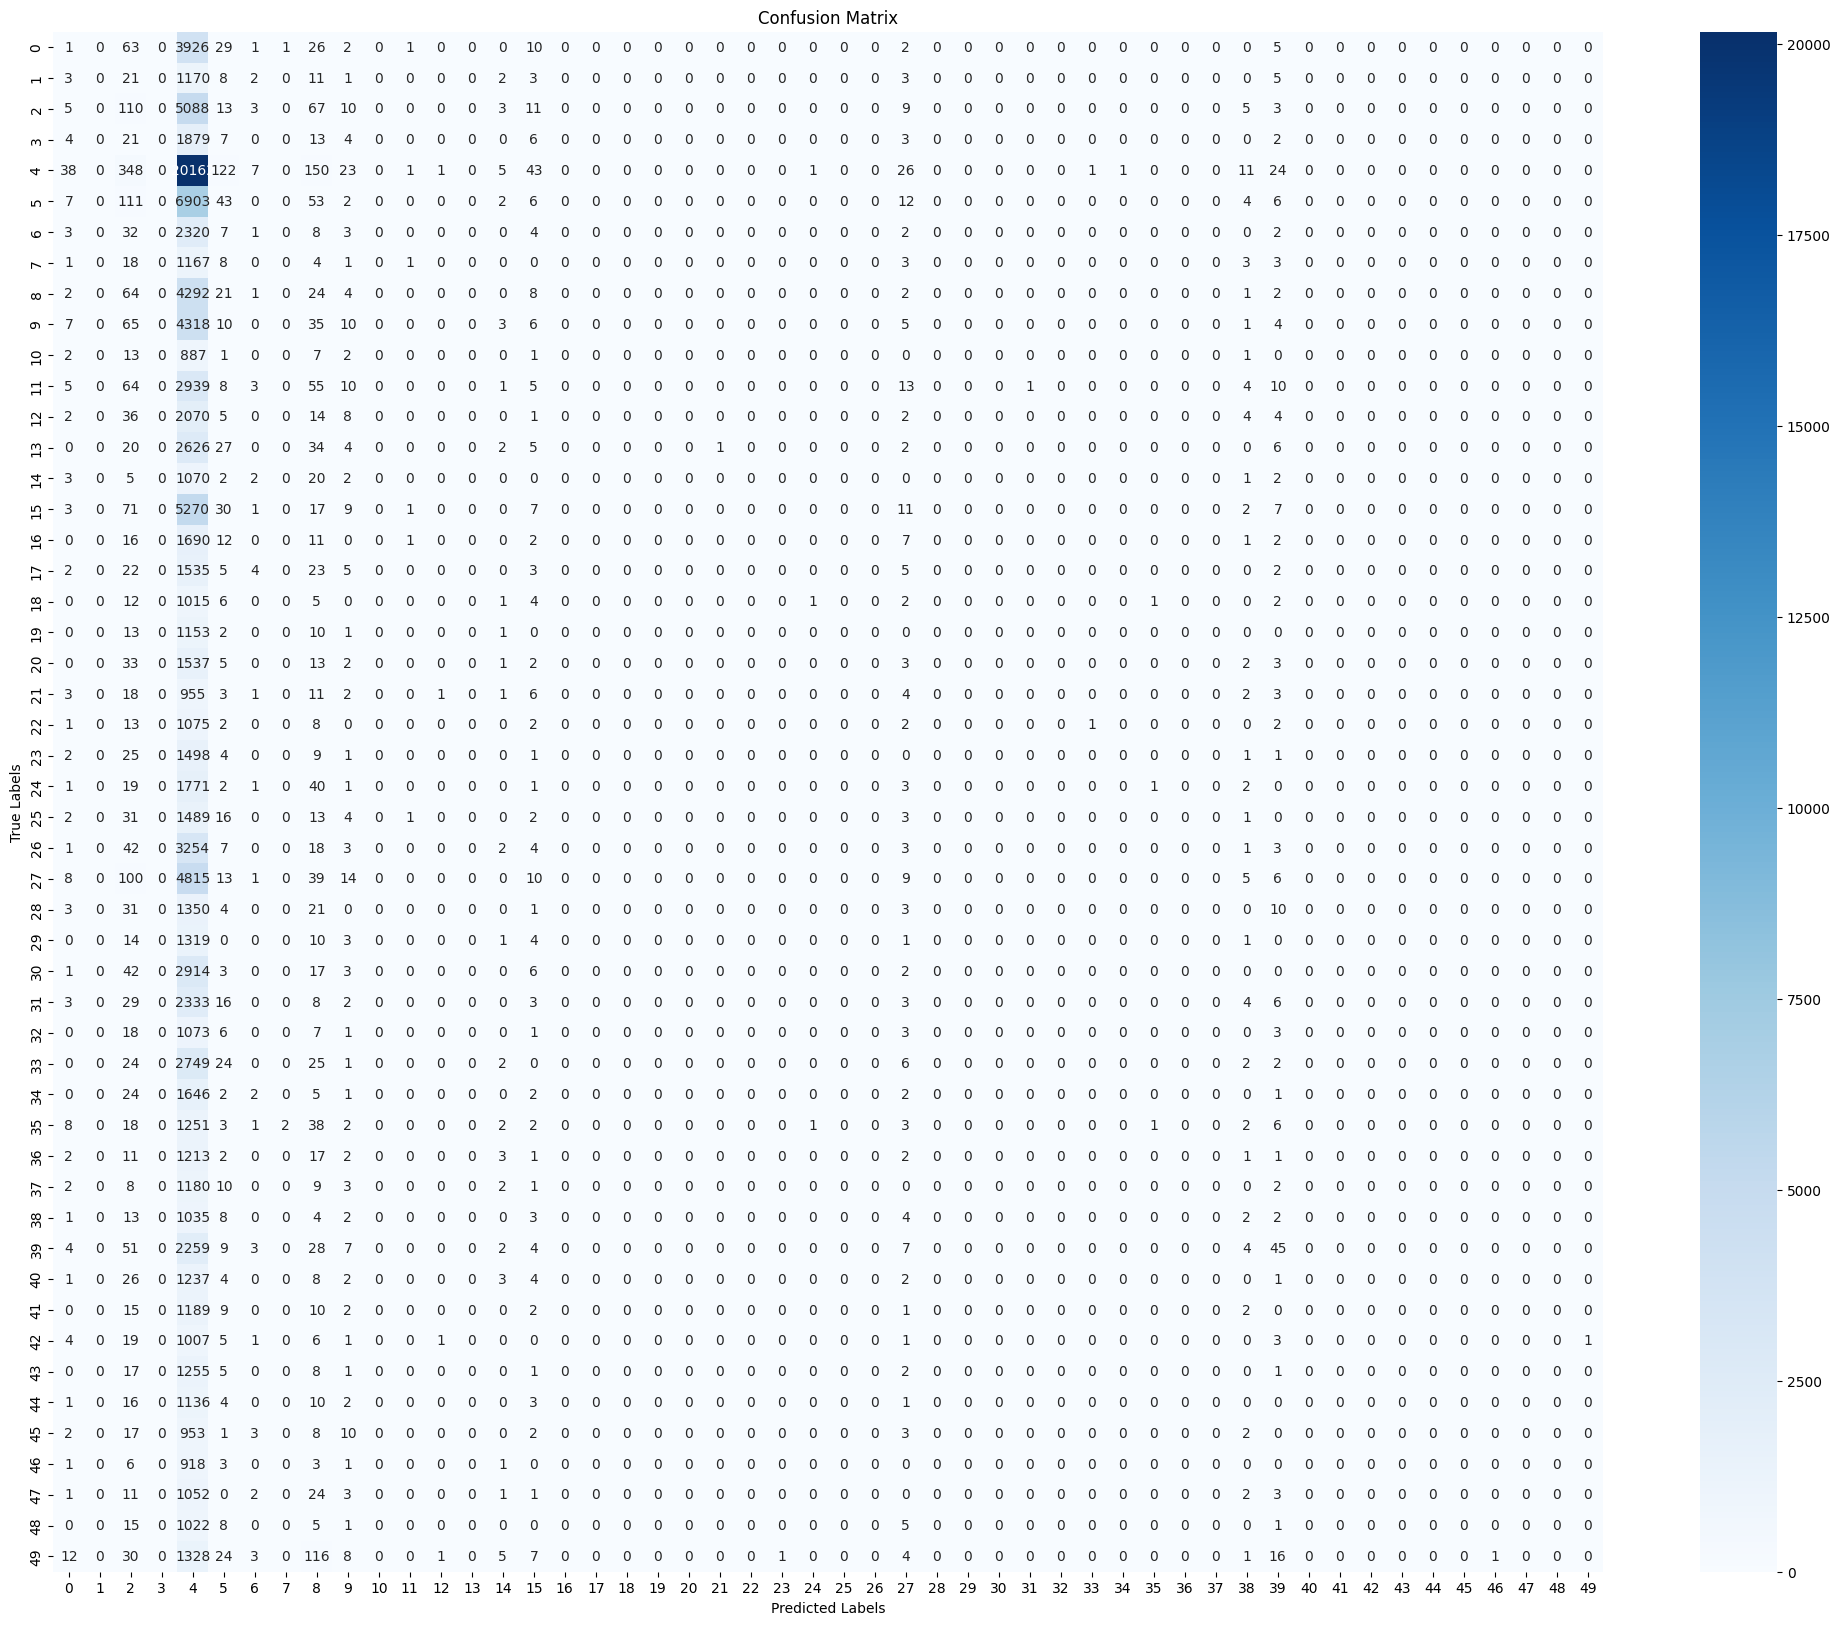

/opt/conda/envs/ptca/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/ptca/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/ptca/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0    0.00658   0.00025   0.00047      4067
           1    0.00000   0.00000   0.00000      1229
           2    0.05911   0.02065   0.03061      5327
           3    0.00000   0.00000   0.00000      1939
           4    0.16901   0.96174   0.28750     20964
           5    0.07570   0.00601   0.01114      7149
           6    0.02326   0.00042   0.00082      2382
           7    0.00000   0.00000   0.00000      1209
           8    0.02133   0.00543   0.00865      4421
           9    0.05376   0.00224   0.00430      4464
          10    0.00000   0.00000   0.00000       914
          11    0.00000   0.00000   0.00000      3118
          12    0.00000   0.00000   0.00000      2146
          13    0.00000   0.00000   0.00000      2727
          14    0.00000   0.00000   0.00000      1107
          15    0.03483   0.00129   0.00249      5429
          16    0.00000   0.00000   0.00000      1742
    

In [15]:
test_fun(validation_dataloader, model)

/opt/conda/envs/ptca/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 5 ========
Training...
  Batch    40  of  15,093.    Elapsed: 0:00:11.
  Batch    80  of  15,093.    Elapsed: 0:00:22.
  Batch   120  of  15,093.    Elapsed: 0:00:33.
  Batch   160  of  15,093.    Elapsed: 0:00:44.
  Batch   200  of  15,093.    Elapsed: 0:00:55.
  Batch   240  of  15,093.    Elapsed: 0:01:06.
  Batch   280  of  15,093.    Elapsed: 0:01:16.
  Batch   320  of  15,093.    Elapsed: 0:01:27.
  Batch   360  of  15,093.    Elapsed: 0:01:38.
  Batch   400  of  15,093.    Elapsed: 0:01:49.
  Batch   440  of  15,093.    Elapsed: 0:02:00.
  Batch   480  of  15,093.    Elapsed: 0:02:10.
  Batch   520  of  15,093.    Elapsed: 0:02:21.
  Batch   560  of  15,093.    Elapsed: 0:02:32.
  Batch   600  of  15,093.    Elapsed: 0:02:43.
  Batch   640  of  15,093.    Elapsed: 0:02:54.
  Batch   680  of  15,093.    Elapsed: 0:03:05.
  Batch   720  of  15,093.    Elapsed: 0:03:16.
  Batch   760  of  15,093.    Elapsed: 0:03:26.
  Batch   800  of  15,093.    Elapsed: 0:03:3

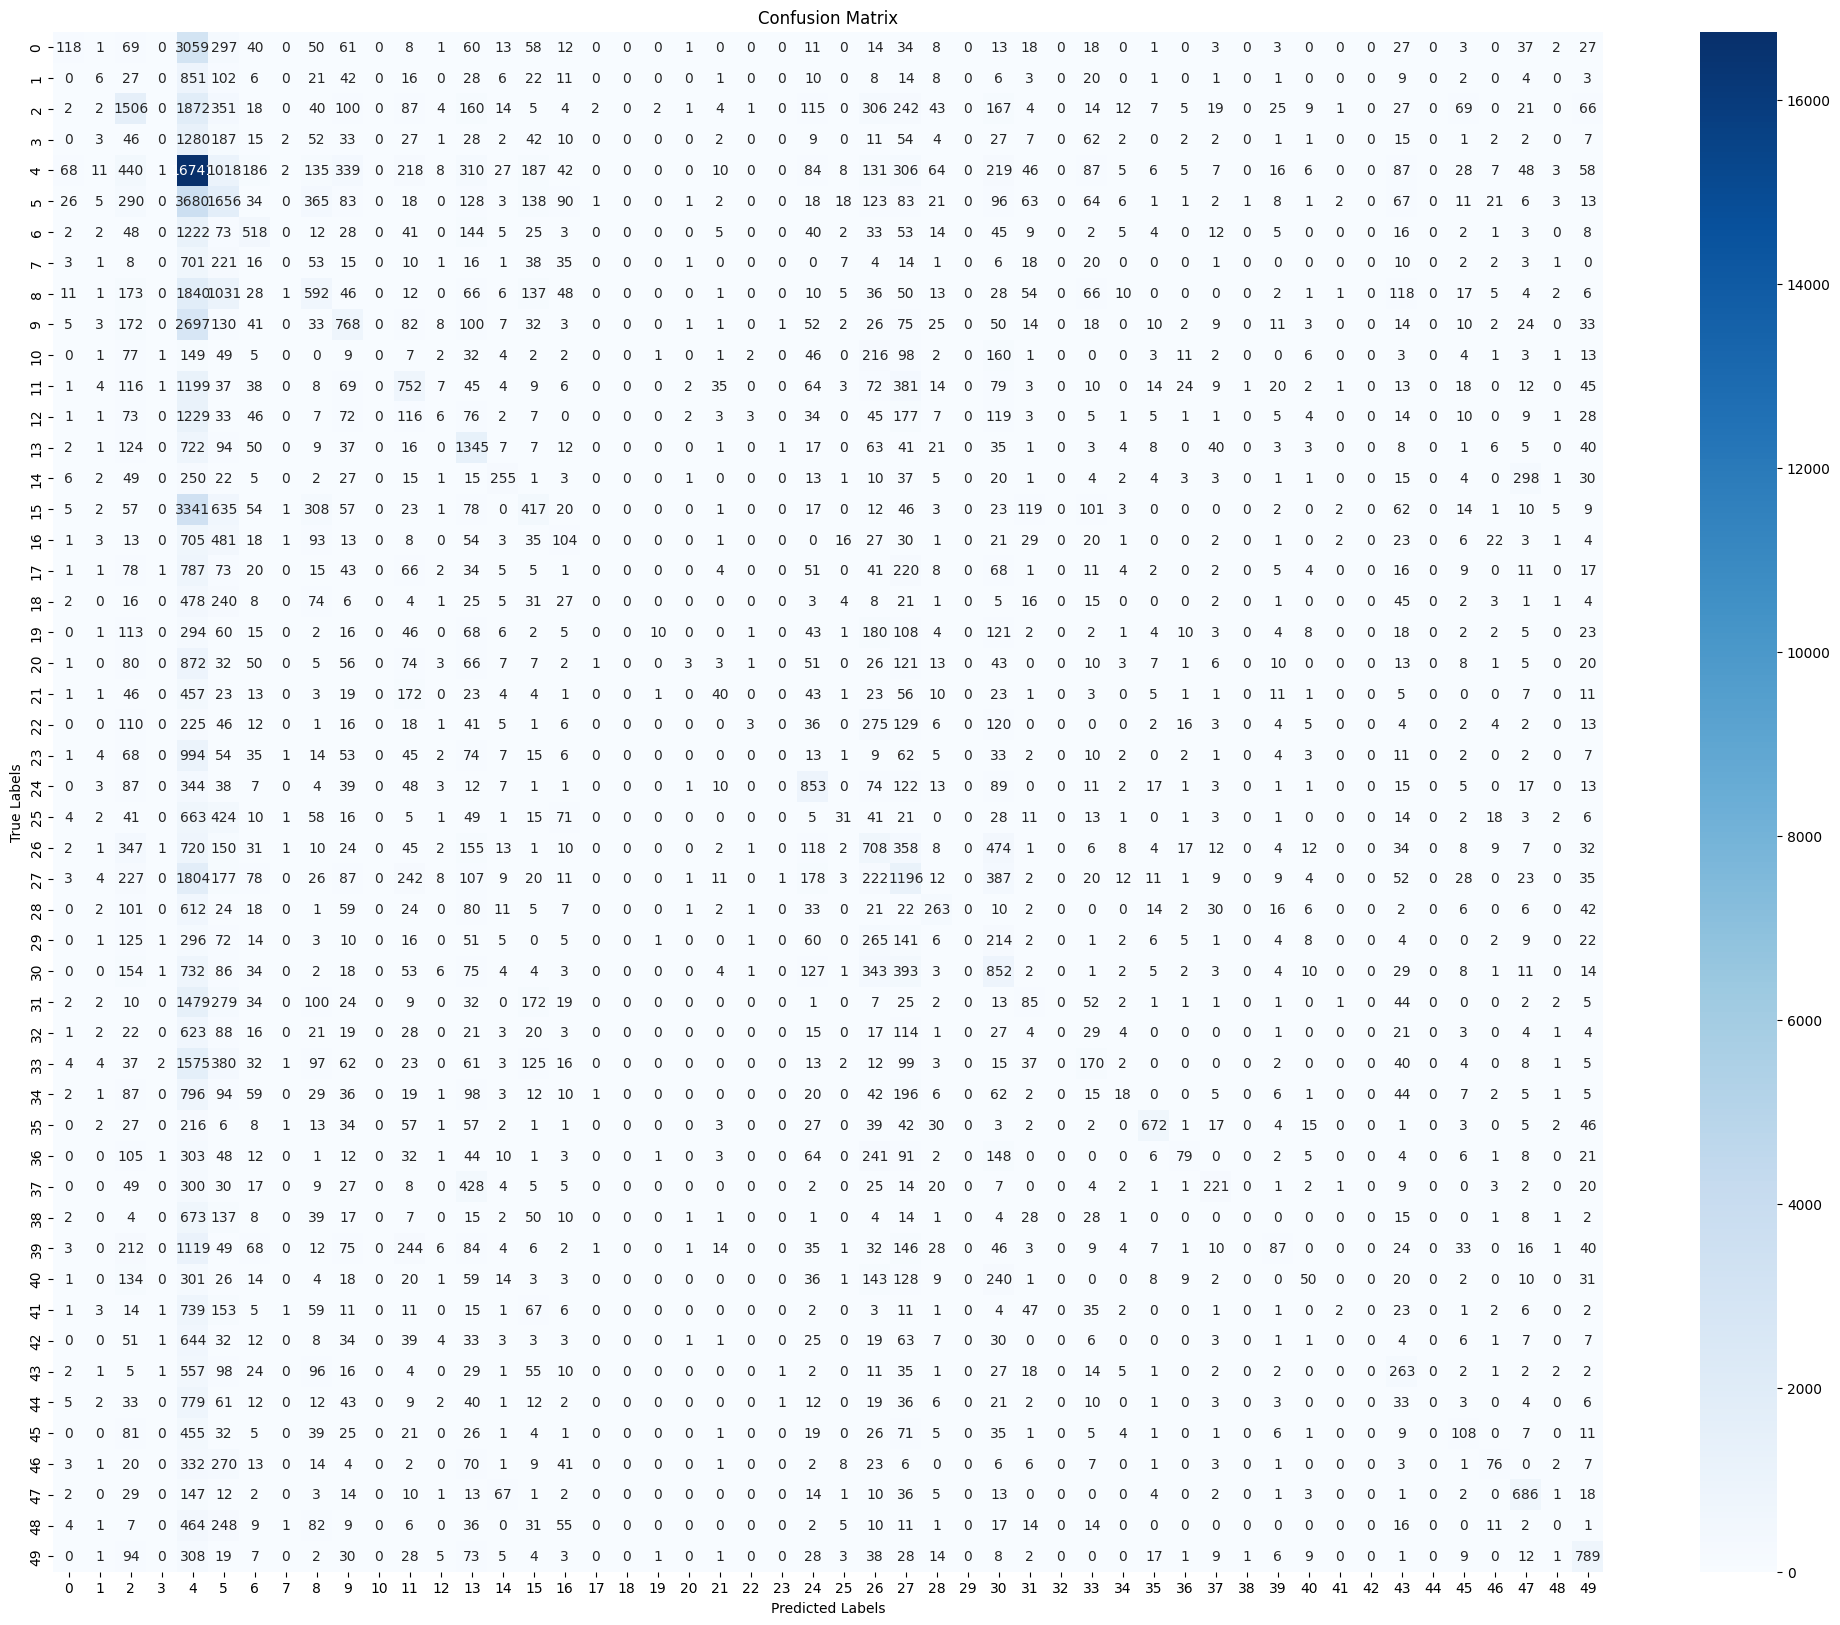

/opt/conda/envs/ptca/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/ptca/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/ptca/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0    0.39597   0.02901   0.05407      4067
           1    0.06742   0.00488   0.00910      1229
           2    0.25517   0.28271   0.26823      5327
           3    0.00000   0.00000   0.00000      1939
           4    0.26732   0.79856   0.40055     20964
           5    0.16597   0.23164   0.19338      7149
           6    0.28462   0.21746   0.24655      2382
           7    0.00000   0.00000   0.00000      1209
           8    0.22441   0.13391   0.16773      4421
           9    0.27716   0.17204   0.21230      4464
          10    0.00000   0.00000   0.00000       914
          11    0.26012   0.24118   0.25029      3118
          12    0.06593   0.00280   0.00536      2146
          13    0.28144   0.49322   0.35838      2727
          14    0.44503   0.23035   0.30357      1107
          15    0.22492   0.07681   0.11451      5429
          16    0.13757   0.05970   0.08327      1742
    

/opt/conda/envs/ptca/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of  15,093.    Elapsed: 0:00:11.
  Batch    80  of  15,093.    Elapsed: 0:00:22.
  Batch   120  of  15,093.    Elapsed: 0:00:33.
  Batch   160  of  15,093.    Elapsed: 0:00:44.
  Batch   200  of  15,093.    Elapsed: 0:00:55.
  Batch   240  of  15,093.    Elapsed: 0:01:05.
  Batch   280  of  15,093.    Elapsed: 0:01:16.
  Batch   320  of  15,093.    Elapsed: 0:01:27.
  Batch   360  of  15,093.    Elapsed: 0:01:38.
  Batch   400  of  15,093.    Elapsed: 0:01:49.
  Batch   440  of  15,093.    Elapsed: 0:02:00.
  Batch   480  of  15,093.    Elapsed: 0:02:10.
  Batch   520  of  15,093.    Elapsed: 0:02:21.
  Batch   560  of  15,093.    Elapsed: 0:02:32.
  Batch   600  of  15,093.    Elapsed: 0:02:42.
  Batch   640  of  15,093.    Elapsed: 0:02:53.
  Batch   680  of  15,093.    Elapsed: 0:03:04.
  Batch   720  of  15,093.    Elapsed: 0:03:15.
  Batch   760  of  15,093.    Elapsed: 0:03:25.
  Batch   800  of  15,093.    Elapsed: 0:03:36.
  Batch   840  of  15,093.    Elapsed: 0

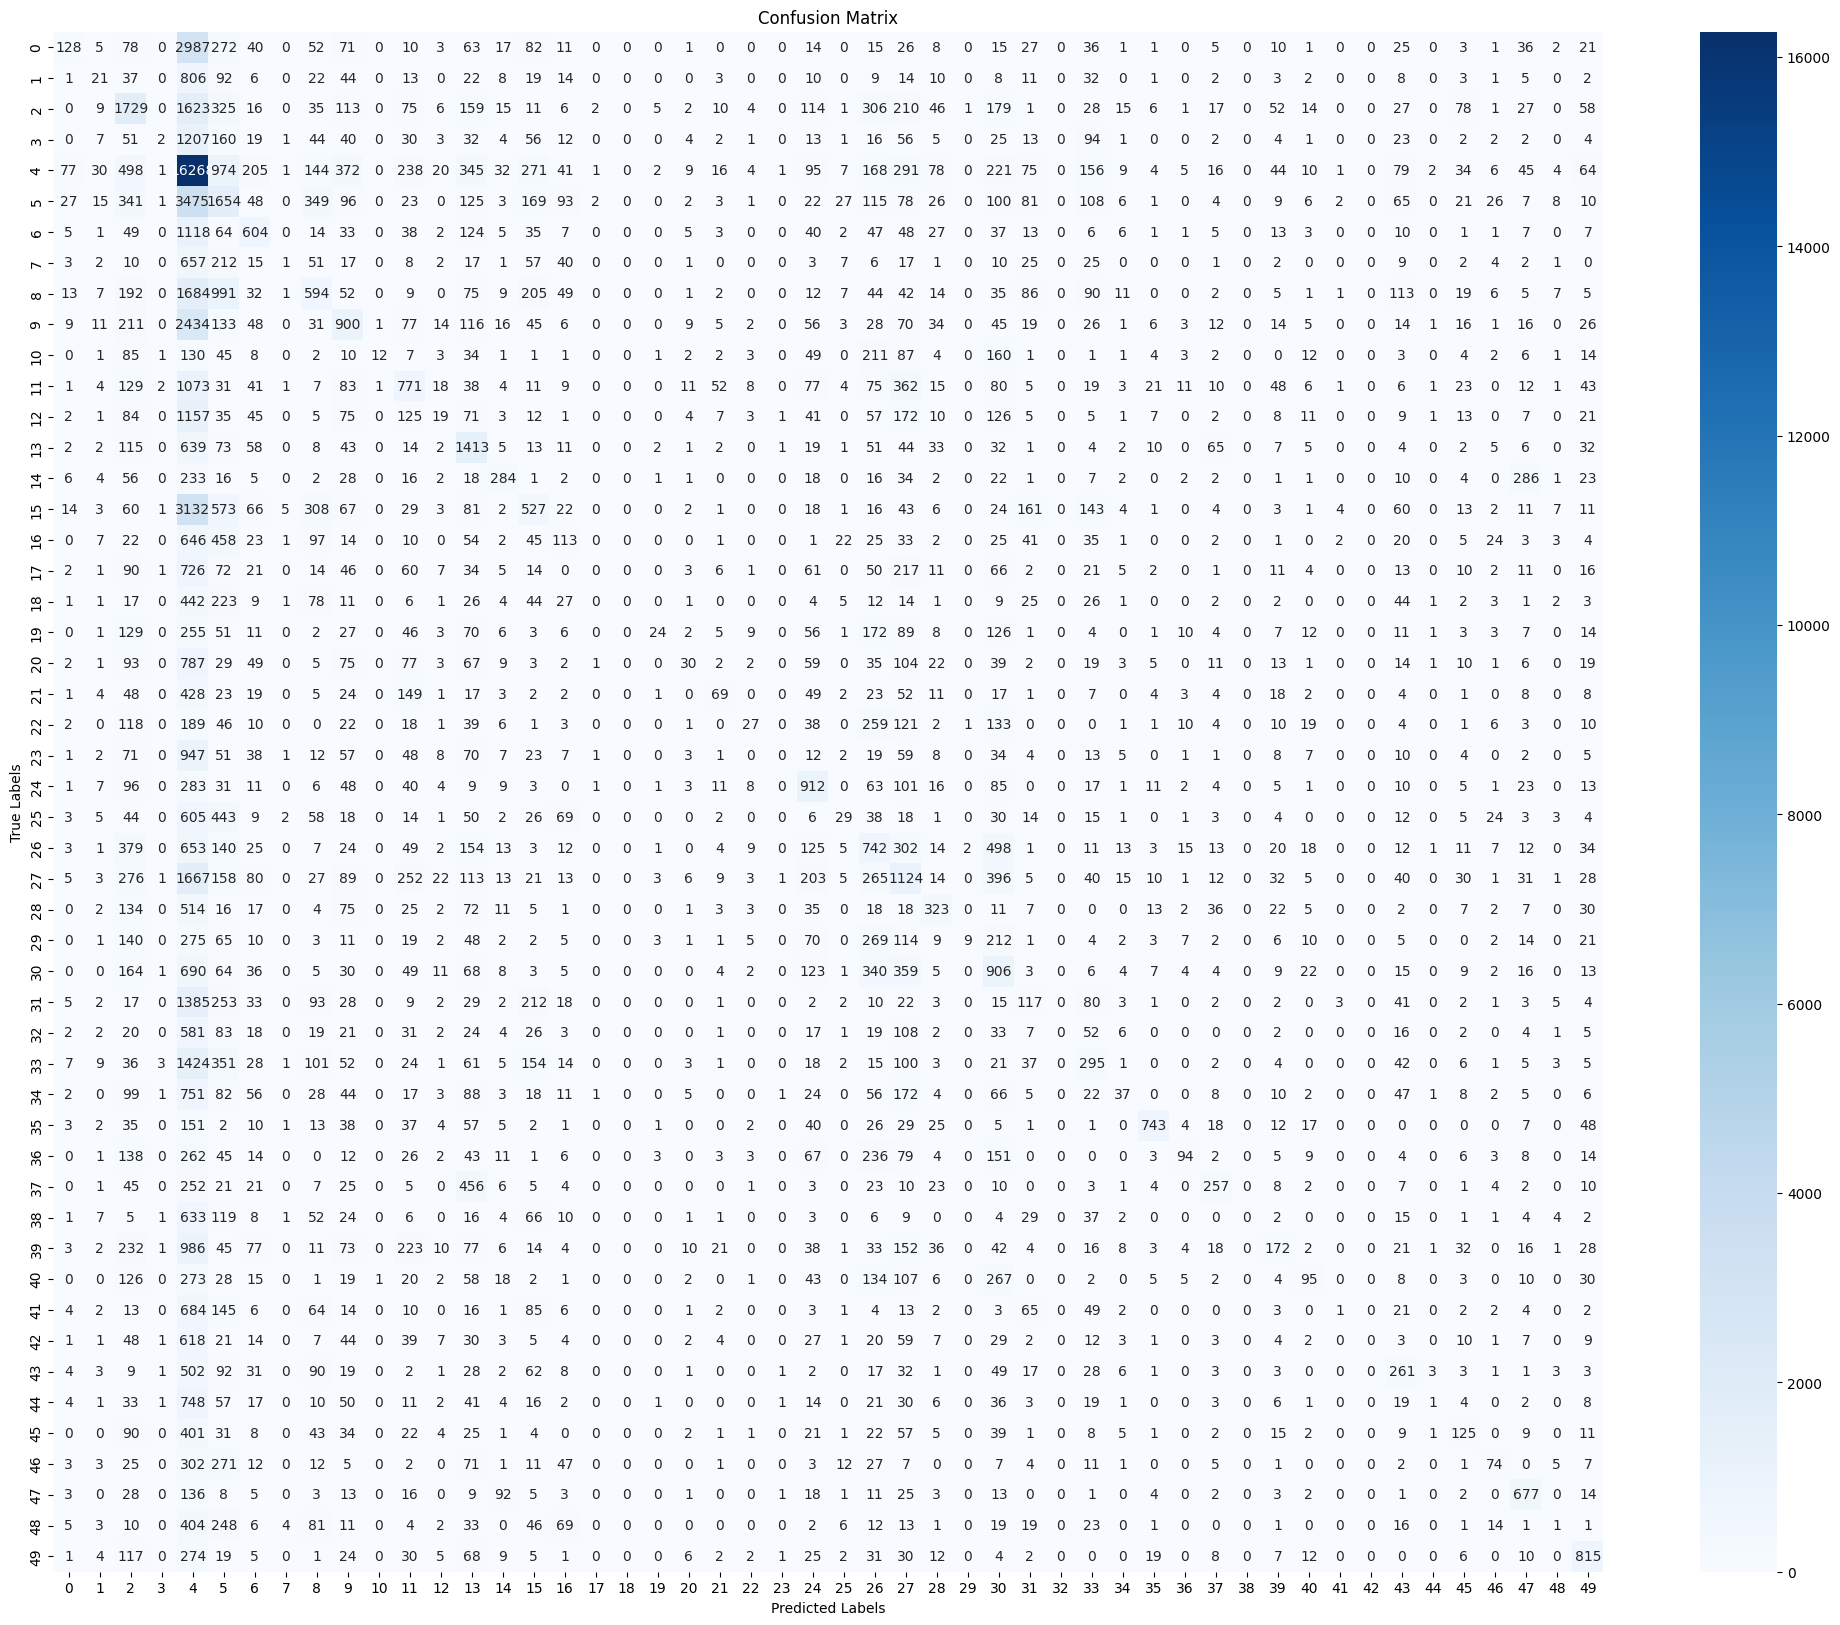

/opt/conda/envs/ptca/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/ptca/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/ptca/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0    0.35854   0.03147   0.05787      4067
           1    0.10396   0.01709   0.02935      1229
           2    0.25914   0.32457   0.28819      5327
           3    0.10000   0.00103   0.00204      1939
           4    0.27810   0.77600   0.40946     20964
           5    0.17519   0.23136   0.19940      7149
           6    0.30080   0.25357   0.27517      2382
           7    0.04545   0.00083   0.00162      1209
           8    0.22611   0.13436   0.16856      4421
           9    0.28436   0.20161   0.23594      4464
          10    0.80000   0.01313   0.02583       914
          11    0.26780   0.24727   0.25713      3118
          12    0.08962   0.00885   0.01612      2146
          13    0.29110   0.51815   0.37277      2727
          14    0.41399   0.25655   0.31679      1107
          15    0.21493   0.09707   0.13374      5429
          16    0.14090   0.06487   0.08884      1742
    

/opt/conda/envs/ptca/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of  15,093.    Elapsed: 0:00:11.
  Batch    80  of  15,093.    Elapsed: 0:00:22.
  Batch   120  of  15,093.    Elapsed: 0:00:33.
  Batch   160  of  15,093.    Elapsed: 0:00:44.
  Batch   200  of  15,093.    Elapsed: 0:00:54.
  Batch   240  of  15,093.    Elapsed: 0:01:06.
  Batch   280  of  15,093.    Elapsed: 0:01:16.
  Batch   320  of  15,093.    Elapsed: 0:01:28.
  Batch   360  of  15,093.    Elapsed: 0:01:38.
  Batch   400  of  15,093.    Elapsed: 0:01:49.
  Batch   440  of  15,093.    Elapsed: 0:02:00.
  Batch   480  of  15,093.    Elapsed: 0:02:11.
  Batch   520  of  15,093.    Elapsed: 0:02:22.
  Batch   560  of  15,093.    Elapsed: 0:02:33.
  Batch   600  of  15,093.    Elapsed: 0:02:44.
  Batch   640  of  15,093.    Elapsed: 0:02:54.
  Batch   680  of  15,093.    Elapsed: 0:03:05.
  Batch   720  of  15,093.    Elapsed: 0:03:16.
  Batch   760  of  15,093.    Elapsed: 0:03:27.
  Batch   800  of  15,093.    Elapsed: 0:03:38.
  Batch   840  of  15,093.    Elapsed: 0

In [16]:
Accs = []
losses = []
f1score = []
top3acc = []
Top3_weightedf1  = []
num_epochs = 5      #change number of epochs if you want
for epoch_i in range(0, num_epochs):
  train_fun(epoch_i, train_dataloader, model , num_epochs)

  print('Data validation>>>')
  test_fun(validation_dataloader, model)

In [ ]:
# plot the accuracy per epoch
# Assuming you have a list called 'accuracy_list'

# Create a list of indices (epochs)
epochs = list(range(len(Accs)))

# Plot the accuracy values against the epochs
plt.plot(epochs, Accs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.grid(True)
plt.show()

In [ ]:
#plot the total loss per epoch

epochs = list(range(len(losses)))

# Plot the accuracy values against the epochs
plt.plot(epochs, losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('loss per Epoch')
plt.grid(True)
plt.show()

In [ ]:
#plot the f1score per epoch

epochs = list(range(len(f1score)))

# Plot the accuracy values against the epochs
plt.plot(epochs, f1score, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Macro avg top 1 f1 score')
plt.title('f1 score per Epoch')
plt.grid(True)
plt.show()

# loading the best model and pushing it to hugging face

In [ ]:
model = torch.load("path to your best model. will be in your directory with name Best_Model.pt")

In [ ]:
!huggingface-cli login --token $"put here your token key, generate it from hugging face website"

In [ ]:
model.push_to_hub("give a meaningful name here about your model")


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)


In [ ]:
tokenizer.push_to_hub("give a meaningful name here about your model")